# Lab 4

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib widget
# %matplotlib inline

DATAFILE = "data/BetaFilter_data_in.dat"
df = pd.read_csv(DATAFILE, sep=" ")
t = df["time"].to_numpy()
y = df["position"].to_numpy()
u = np.zeros(len(y))
Ts = t[1] - t[0]

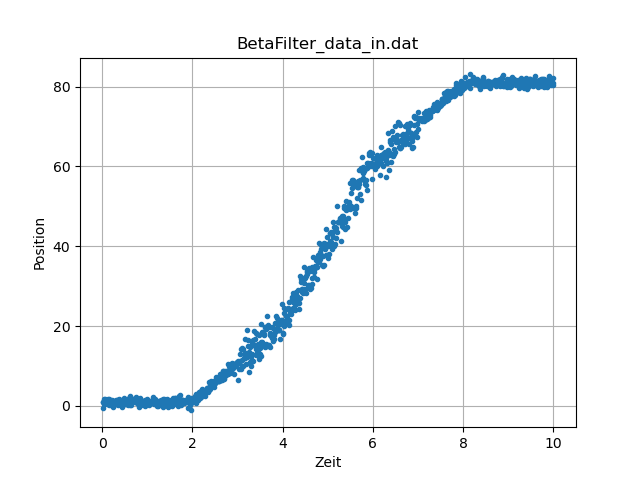

In [93]:
plt.figure()
plt.title("BetaFilter_data_in.dat")
plt.xlabel("Zeit")
plt.ylabel("Position")
plt.grid(True)
plt.plot(t, y, ".")
plt.show()


In [94]:
stable_s = y[t < 2]  # stable range from 0-2 and 8-* see plot above
# R = stable_s[~np.isnan(stable_s)].var()
R = stable_s.var()
Q = [R / 100]
print(f"{R=:g}")
print(f"{Q[0]=:g}")


R=0.389682
Q[0]=0.00389682


### Beta-Filter

$$
\boldsymbol{x}(k + 1) = \begin{bmatrix}
1 & T_s \\
0 & 1 \\
\end{bmatrix} \cdot \begin{bmatrix}
s(k) \\
v(k)
\end{bmatrix} + \begin{bmatrix}
0 \\
0 \\
\end{bmatrix} \cdot \boldsymbol{u}(k) + \begin{bmatrix}
T_s \\
1 \\
\end{bmatrix} \cdot \boldsymbol{z}(k)
$$

$$
\boldsymbol{y}(k) = s(t) = \begin{bmatrix}
1 & 0 \\
\end{bmatrix} \cdot \begin{bmatrix}
s(t) \\
v(t) \\
\end{bmatrix} + \begin{bmatrix}
0 \\
\end{bmatrix} \cdot u(k)
$$


In [95]:
# Define system matrices
Ad = np.array(
    [
        [1, Ts],
        [0, 1],
    ]
)
Bd = np.array(
    [
        [0],
        [0],
    ]
)
C = np.array([1, 0])
D = np.array([0])
Gd = np.array(
    [
        [Ts],
        [1],
    ]
)

# Initialization
x_dach = np.array([[y[0]], [0]])  # estimate
P_dach = 30 * np.eye(Bd.size)

s = np.zeros(len(y))  # prediction output array
v = np.zeros(len(y))  # variation
d_y = np.zeros(len(y))  # new error
y_dach = np.zeros(len(y))  # error

P_tilde0 = np.zeros(len(y))
P_tilde1 = np.zeros(len(y))
P_tilde2 = np.zeros(len(y))
P_tilde3 = np.zeros(len(y))


In [96]:
for i, y_i in enumerate(y):
    y_dach[i] = C @ x_dach + D * u[i]
    d_y[i] = y_i - y_dach[i]
    # K = P_dach @ C.reshape(-1,1) * (C @ P_dach @ C.reshape(-1,1) + R) ** (-1) # previous method
    k = C @ P_dach @ C.reshape(-1, 1) + R
    if k.ndim >= 2:
        K = (
            P_dach @ C.reshape(-1, 1) @ np.linalg.pinv(k)
        )  # penrose inverse works with k dimension greater 2
    else:
        K = P_dach @ C.reshape(-1, 1) / k  # use plain inverse otherwise

    x_tilde = x_dach + K * d_y[i]
    P_tilde = (np.eye(Bd.size) - K * C) @ P_dach
    # print(P_tilde)

    x_dach = Ad @ x_tilde + Bd * u[i]
    P_dach = Ad @ P_tilde @ Ad.T + Gd @ Q * Gd.T

    s[i], v[i] = x_tilde

    P_tilde0 = P_tilde[0][0]
    P_tilde1 = P_tilde[0][1]
    P_tilde2 = P_tilde[1][0]
    P_tilde3 = P_tilde[1][1]


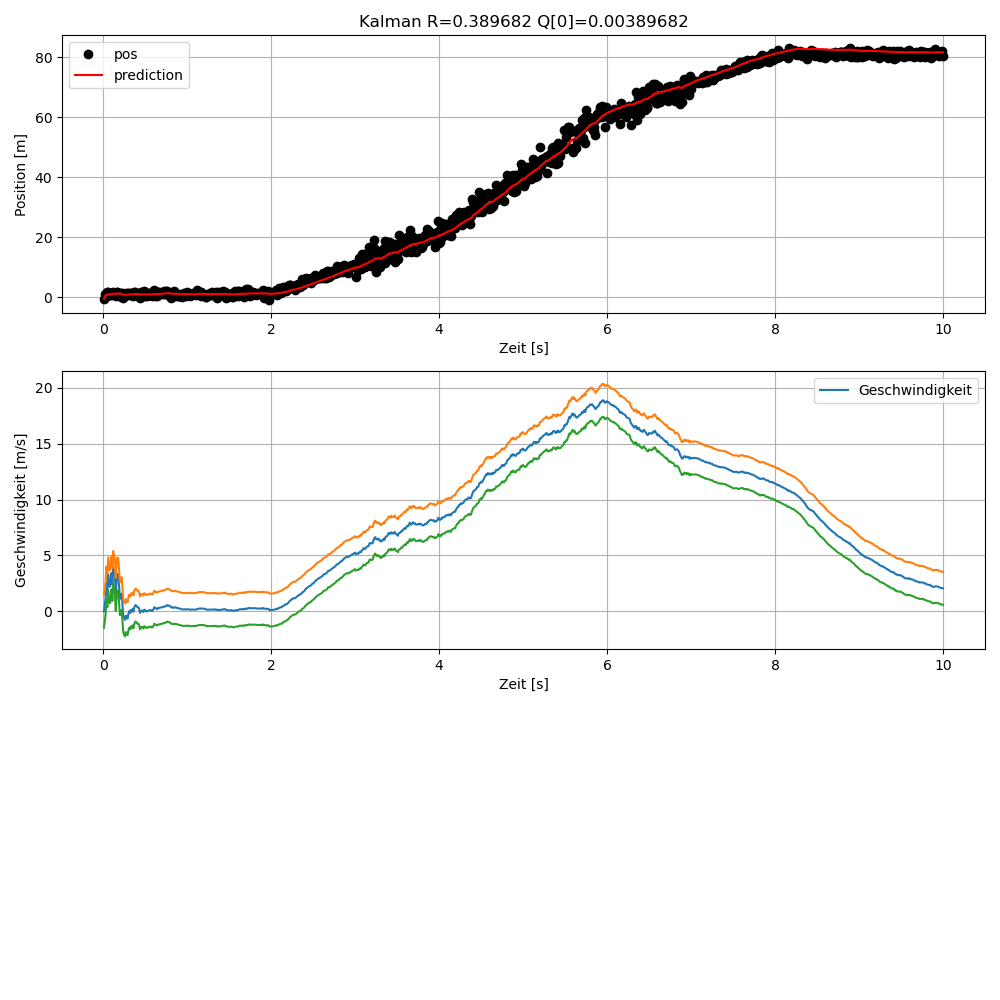

In [97]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.title(f"Kalman {R=:g} {Q[0]=:g}")
plt.xlabel("Zeit")
plt.grid(True)
plt.plot(t, y, "ko", label="pos")
plt.plot(t, s, "r-", label="prediction")
# plt.plot(t, s + 5 * np.sqrt(P_tilde0), "-")
# plt.plot(t, s - 5 * np.sqrt(P_tilde0), "-")
plt.xlabel("Zeit [s]")
plt.ylabel("Position [m]")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, v, "-", label="Geschwindigkeit")
plt.plot(t, v + 5 * np.sqrt(P_tilde3), "-")
plt.plot(t, v - 5 * np.sqrt(P_tilde3), "-")
plt.xlabel("Zeit [s]")
plt.ylabel("Geschwindigkeit [m/s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
